In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [15]:
# Set path and parameters
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
image_size = 128

# Load data
def load_data(folder):
    X, y = [], []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(data_dir, folder, label)
        class_num = 0 if label == 'NORMAL' else 1
        for img_name in tqdm(os.listdir(path), desc=f"Loading {label}"):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (image_size, image_size))
            img = img / 255.0
            img = np.expand_dims(img, axis=-1)
            X.append(img)
            y.append(class_num)
    return np.array(X), np.array(y)

Loading PNEUMONIA: 100%|██████████| 390/390 [00:01<00:00, 199.23it/s]


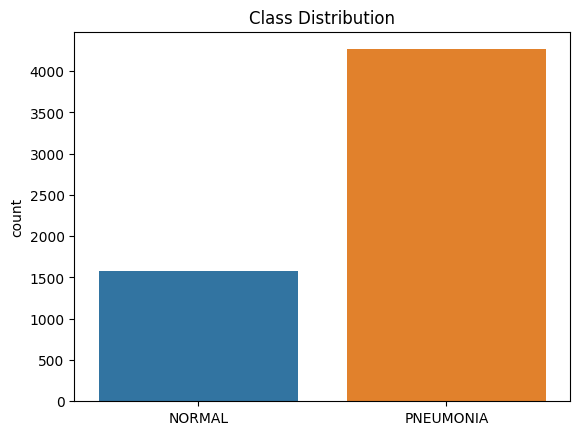

In [16]:
# Combine train + test folders
X_train_raw, y_train_raw = load_data('train')
X_test_raw, y_test_raw = load_data('test')
X_raw = np.concatenate([X_train_raw, X_test_raw])
y_raw = np.concatenate([y_train_raw, y_test_raw])

# Visualize class distribution
sns.countplot(x=y_raw)
plt.xticks([0,1], ['NORMAL', 'PNEUMONIA'])
plt.title('Class Distribution')
plt.show()


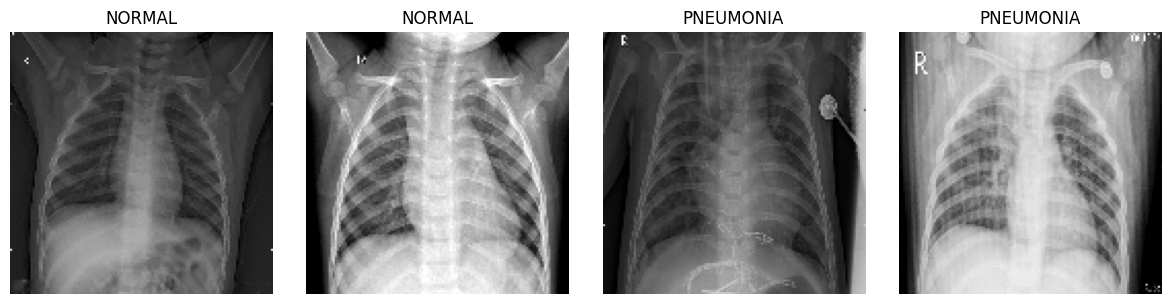

In [17]:
# Sample images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, label in enumerate([0, 1]):
    imgs = X_raw[y_raw == label][:2]
    for j in range(2):
        axes[2*i + j].imshow(imgs[j].squeeze(), cmap='gray')
        axes[2*i + j].axis('off')
        axes[2*i + j].set_title('NORMAL' if label == 0 else 'PNEUMONIA')
plt.tight_layout()
plt.show()

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

In [23]:
X_train = X_train.reshape(-1, 1, 128, 128)
X_test = X_test.reshape(-1, 1, 128, 128)


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Define CNN model
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 14 * 14, 128) 
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (batch, 32, 63, 63)
        x = self.pool(F.relu(self.conv2(x)))  # (batch, 64, 30, 30)
        x = self.pool(F.relu(self.conv3(x)))  # (batch, 128, 14, 14)
        x = x.view(-1, 128 * 14 * 14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

# Convert your NumPy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PneumoniaCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [26]:
train_losses = []
train_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 0.4718, Accuracy: 0.7791
Epoch 2, Loss: 0.2515, Accuracy: 0.8949
Epoch 3, Loss: 0.2094, Accuracy: 0.9208
Epoch 4, Loss: 0.1833, Accuracy: 0.9332
Epoch 5, Loss: 0.1704, Accuracy: 0.9379
Epoch 6, Loss: 0.1555, Accuracy: 0.9437
Epoch 7, Loss: 0.1468, Accuracy: 0.9516
Epoch 8, Loss: 0.1423, Accuracy: 0.9510
Epoch 9, Loss: 0.1405, Accuracy: 0.9514
Epoch 10, Loss: 0.1257, Accuracy: 0.9568


In [37]:
# Evaluate and collect probabilities for ensemble
model.eval()
cnn_probs = []
cnn_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = outputs.cpu().numpy().squeeze()
        cnn_probs.extend(probs)
        cnn_labels.extend(labels.numpy().squeeze())

cnn_probs = np.array(cnn_probs)
cnn_preds = (cnn_probs > 0.5).astype(int)
cnn_accuracy = accuracy_score(cnn_labels, cnn_preds)

print(f"CNN Accuracy: {cnn_accuracy:.4f}")


CNN Accuracy: 0.9521


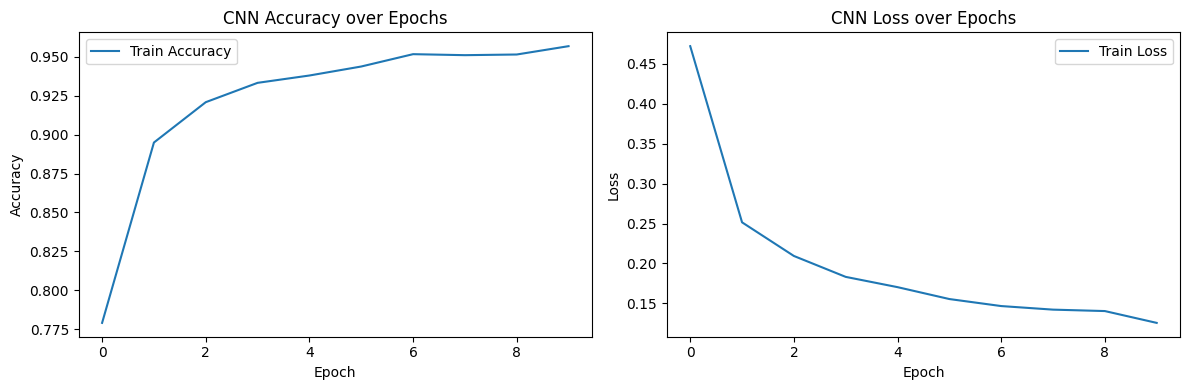

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (4672, 1, 128, 128)
X_test shape: (1168, 1, 128, 128)


In [31]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_flat, y_train)

# Predict and evaluate
svm_preds = svm_model.predict(X_test_flat)
svm_accuracy = accuracy_score(y_test, svm_preds)

print(f"SVM Accuracy: {svm_accuracy:.4f}")


SVM Accuracy: 0.9495


In [33]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# Predict and evaluate
rf_preds = rf_model.predict(X_test_flat)
rf_accuracy = accuracy_score(y_test, rf_preds)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.9384


In [34]:
svm_probs = svm_model.predict_proba(X_test_flat)[:, 1]
rf_probs = rf_model.predict_proba(X_test_flat)[:, 1]

In [38]:
# Average the predicted probabilities
ensemble_probs = (cnn_probs + svm_probs + rf_probs) / 3

# Convert averaged probabilities to binary labels
ensemble_preds = (ensemble_probs > 0.5).astype(int)


In [39]:
from sklearn.metrics import accuracy_score, classification_report

# Ensemble accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Compare with individual models
print(f"CNN Accuracy: {cnn_accuracy:.4f}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Ensemble Accuracy: 0.9572
CNN Accuracy: 0.9521
SVM Accuracy: 0.9495
Random Forest Accuracy: 0.9384


In [40]:
print("\nEnsemble Classification Report:")
print(classification_report(y_test, ensemble_preds))


Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       315
           1       0.96      0.98      0.97       853

    accuracy                           0.96      1168
   macro avg       0.95      0.94      0.94      1168
weighted avg       0.96      0.96      0.96      1168



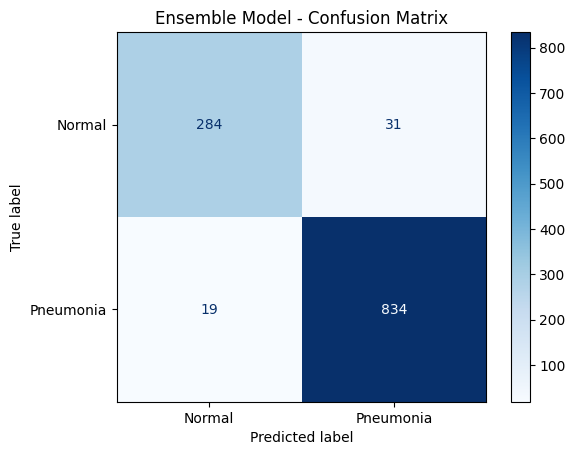

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap='Blues')
plt.title("Ensemble Model - Confusion Matrix")
plt.show()


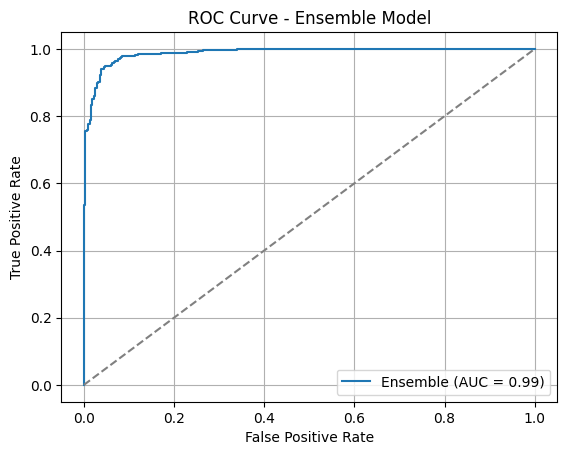

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, ensemble_probs)
auc_score = roc_auc_score(y_test, ensemble_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'Ensemble (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend()
plt.grid(True)
plt.show()

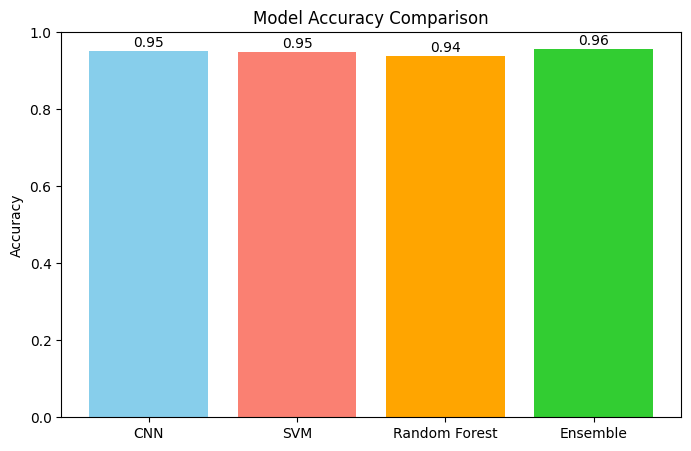

In [43]:
model_names = ['CNN', 'SVM', 'Random Forest', 'Ensemble']
accuracies = [cnn_accuracy, svm_accuracy, rf_accuracy, ensemble_accuracy]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'salmon', 'orange', 'limegreen'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Add accuracy values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center')

plt.show()

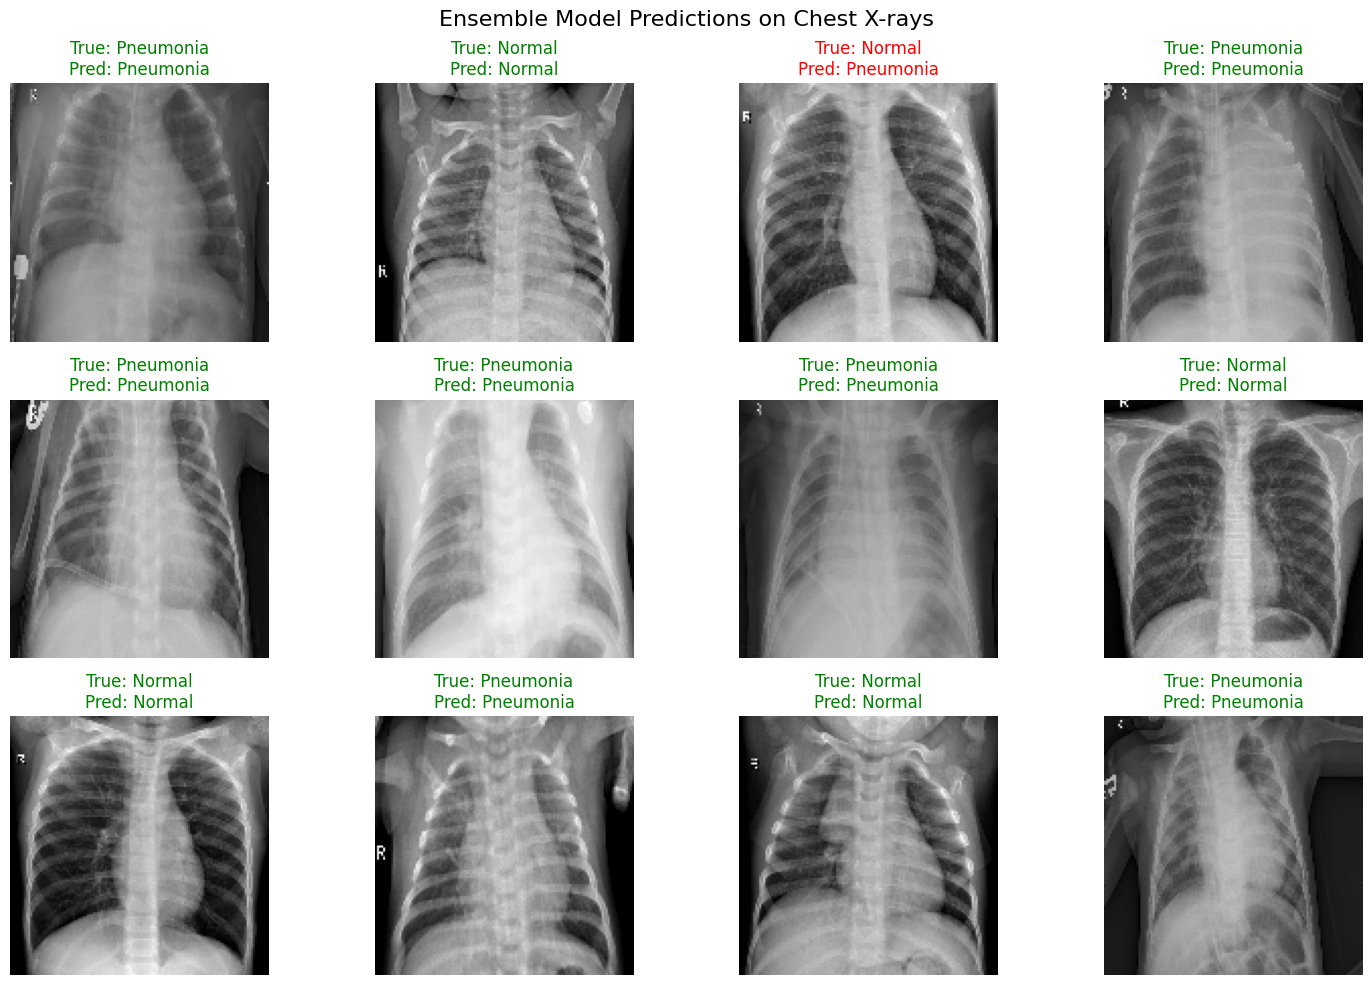

In [44]:
import matplotlib.pyplot as plt
import numpy as np


num_images = 12
indices = np.random.choice(len(X_test), num_images, replace=False)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    image = X_test[idx].squeeze()  # shape (128, 128)
    true_label = int(y_test[idx])
    pred_label = int(ensemble_preds[idx])

    plt.subplot(3, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'True: {"Pneumonia" if true_label else "Normal"}\nPred: {"Pneumonia" if pred_label else "Normal"}',
              color='green' if true_label == pred_label else 'red')
    plt.axis('off')

plt.suptitle('Ensemble Model Predictions on Chest X-rays', fontsize=16)
plt.tight_layout()
plt.show()
